# Initial set up

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import os
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '_CURRENT/“COOP/UncertaintyPaper'
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))
GOOGLE_DRIVE_PATH = os.path.join('.')

In [3]:
import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [4]:
import numpy as np
import torch.nn as nn
import pickle
import random
import torch
from torch.autograd import Variable
from numpy import genfromtxt
from matplotlib import pylab as plt

# Create train / val / test datasets

In [5]:
def getScale(path, models):
    bound_list = []
    for model in models:
        bound_file = str(model) + '_bound.csv'
        bound = genfromtxt(os.path.join(path, bound_file), delimiter=',')
        bound_list.append(bound)
    bound_list = np.array(bound_list)        
    scale = np.array([np.max(bound_list[:, :, 0], axis=0), np.min(bound_list[:, :, 1], axis=0)])
    abs_scale = np.max(abs(scale), axis=0)
    return abs_scale

def makeTrainingSet(path, model, correct_idx, problem_idx, abs_scale):

    out_pkl = str(model) + '.pkl'
    files = os.listdir(path)
    all_data = []
    for file in files:
        pkl_files = os.listdir(os.path.join(path, file))
        for pkl_file in pkl_files:
            with open(os.path.join(path, file, pkl_file), 'rb') as f:
                one_sample = pickle.load(f)
                if len(one_sample) != 159:
                    continue
                if len(one_sample[0]) != 88:
                    continue
                one_sample = np.array(one_sample)
                if one_sample.shape != (159, 88):
                    continue
                all_data.append(one_sample)

    all_data = np.array(all_data)
    Z = all_data[:, :, correct_idx]
    X = all_data[:, :, problem_idx]
    all_data = np.concatenate((Z, X), axis=2)

    # Normalization
    for i in range(all_data.shape[2]):
        all_data[:, :, i] /= abs_scale[i]
    # Save normalized pkl files
    pickle.dump(all_data, open(out_pkl, 'ab'))
    
def makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, kind):
    sub_paths = os.listdir(path)
    all_data = []
    for sub_path in sub_paths:
        out_pkl = str(model) + '_' + kind + '.pkl'
        files = os.listdir(os.path.join(path, sub_path))
        
        for file in files:
            pkl_files = os.listdir(os.path.join(path, sub_path, file))
            for pkl_file in pkl_files:
                with open(os.path.join(path, sub_path, file, pkl_file), 'rb') as f:
                    one_sample = pickle.load(f)
                    if len(one_sample) != 159:
                        continue
                    if len(one_sample[0]) != 88:
                        continue
                    one_sample = np.array(one_sample)
                    if one_sample.shape != (159, 88):
                        continue
                    all_data.append(one_sample)

    all_data = np.array(all_data)
    Z = all_data[:, :, correct_idx]
    X = all_data[:, :, problem_idx]
    all_data = np.concatenate((Z, X), axis=2)

    # Normalization
    for i in range(all_data.shape[2]):
        all_data[:, :, i] /= abs_scale[i]
    # Save normalized pkl files
    pickle.dump(all_data, open(out_pkl, 'ab'))

In [6]:
models = [442, 607, 612, 614, 616, 617, 620, 714, 722]

In [ ]:
# path = "../meta/meta_bound"
# abs_scale = getScale(path, models)

# # Set sensor index
# raw_problem_idx = [49, 50, 51, 52, 53, 54, 87,
#                    10, 11, 12, 13, 14, 16, 17, 19, 29]
# raw_correct_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 31, 34, 41, 44, 60]
# correct_idx = []
# problem_idx = []
# # M1inus one for each index
# for idx in raw_correct_idx:
#     correct_idx.append(idx - 1)
# correct_l = len(correct_idx)

# for idx in raw_problem_idx:
#     problem_idx.append(idx - 1)
# problem_l = len(problem_idx)

In [ ]:
# path_general = "../new_gan"
# for model in models:
#     path = os.path.join(path_general, str(model), "train")
#     makeTrainingSet(path, model, correct_idx, problem_idx, abs_scale)

In [ ]:
# path_general = "../new_gan"
# for model in models:
#     path = os.path.join(path_general, str(model), "val")
#     makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, "val")

# for model in models:
#     path = os.path.join(path_general, str(model), "test")
#     makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, "test")

# for model in models:
#     path = os.path.join(path_general, str(model), "ab")
#     makeValidationSet(path, model, correct_idx, problem_idx, abs_scale, "ab")

In [9]:
training = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + ".pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        training[model] = one_sample

In [10]:
validation = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + "_val.pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        length = one_sample.shape[0]
        select_list = [i for i in range(length)]
        random.shuffle(select_list)
        validation[model] = one_sample[select_list, :]

In [21]:
ab = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + "_ab.pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        ab[model] = one_sample

In [22]:
test = {}
for model in models:
    with open(os.path.join(GOOGLE_DRIVE_PATH, 'data', str(model) + "_test.pkl"), 'rb') as f:
        one_sample = pickle.load(f)
        one_sample = torch.from_numpy(one_sample).to(dtype=torch.float32)
        test[model] = one_sample

# Models

## NP_LSTM

In [11]:
## Network structure
class NP_LSTM(nn.Module):
    def __init__(self):
        super(NP_LSTM, self).__init__()
        self.r_dim = 128
        self.z_dim = 128
        self.h_param = 500
        self.g_param = 500

        # LSTM parameters
        self.x_dim = 14
        self.y_dim = 16
        self.input_dim = 30
        self.output_dim = 16
        self.hidden_dim = 500
        self.num_layers = 2
        self.lstm_h = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.lstm_g = nn.LSTM(self.x_dim + self.z_dim, self.hidden_dim, self.num_layers)
        # Define output layer
        # self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        self.g_l = nn.Linear(self.g_param, self.output_dim)

        self.h_l = nn.Linear(self.h_param, self.r_dim)

        self.r_to_z_mean = nn.Linear(self.r_dim, self.z_dim)
        self.r_to_z_log_var = nn.Linear(self.r_dim, self.z_dim)

    def point_grad_to(self, target):
        '''
        Set .grad attribute of each parameter to be proportional
        to the difference between self and target
        '''
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                # if self.is_cuda():
                p.grad = Variable(torch.zeros(p.size())).cuda()
                # else:
                #     p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.zero_()  # not sure this is required
            p.grad.data.add_(p.data - target_p.data)

    def aggregate(self, rc):
        return torch.mean(rc, dim=0)

    def h(self, input):
        h_out, self.hidden = self.lstm_h(input)
        h_out = self.h_l(h_out)
        return h_out

    def g(self, input):
        g_out, _ = self.lstm_g(input, self.hidden)
        g_out = self.g_l(g_out)
        return g_out

    def xy_to_z(self, x, y):
        context = torch.cat([x, y], dim=2)
        rc = self.h(context)
        r = self.aggregate(rc)
        mu = self.r_to_z_mean(r)
        log_var = self.r_to_z_log_var(r)
        return mu, log_var

    def xz_to_y(self, x, z):
        std = torch.exp(0.5 * z[0])
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(z[1])
        z = z.unsqueeze(0).expand(self.output_length, -1, -1)
        y = self.g(torch.cat([z, x], dim=2))
        return y

    def forward(self, x_context, y_context, x_target, x_all=None, y_all=None):
        # context = torch.cat([x_context, y_context.unsqueeze(2)], dim=2)
        # rC = self.h(context)
        # r = torch.mean(rC, dim=1)
        # mu = self.r_to_z_mean(r)
        # logVar = self.r_to_z_logVar(r)
        self.output_length = x_target.shape[0]
        z_context = self.xy_to_z(x_context, y_context)
        if x_all is not None:
            z_all = self.xy_to_z(x_all, y_all)
        else:
            z_all = None

        y_pred = self.xz_to_y(x_target, z_context)
        return y_pred, z_context, z_all

### NP-specific losses

In [12]:
def kl_div_gaussians(mu_q, logvar_q, mu_p, logvar_p):
    var_p = torch.exp(logvar_p)
    kl_div = (torch.exp(logvar_q) + (mu_q - mu_p) ** 2) / var_p - 1.0 + logvar_p - logvar_q
    kl_div = 0.5 * kl_div.sum()
    return kl_div


def np_loss(y_pred, y_target, z_all, z_context):
    MSELoss = torch.nn.MSELoss()(y_pred, y_target)
    KLD = kl_div_gaussians(z_all[0], z_all[1], z_context[0], z_context[1])
    return MSELoss + KLD

## LSTM

In [13]:
## Network structure
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.input_dim = 14
        self.hidden_dim = 500
        self.num_layers = 2
        self.output_dim = 16
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        # Define output layer
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
#         self.tanh = nn.Tanh()

    def point_grad_to(self, target):
        '''
        Set .grad attribute of each parameter to be proportional
        to the difference between self and target
        '''
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                # if self.is_cuda():
                p.grad = Variable(torch.zeros(p.size())).cuda()
                # else:
                #     p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.zero_()  # not sure this is required
            p.grad.data.add_(p.data - target_p.data)

    def forward(self, x):
        # shape of input  (seq_length, batch, input_dim)
        # shape of output (seq_length, batch, hidden_dim)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out)
#         y_pred = self.tanh(y_pred)
        return y_pred

### MSE loss

In [14]:
MSELoss = torch.nn.MSELoss()

# Training

In [15]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

## NP_LSTM with meta learning

In [ ]:
# Start training
Step = 4000 # 4000
batch_size = 16
meta_lr = 1e-3
meta_lr_decay = 0.1
schedule = [1000, 2000, 3000]
update_lr = 1e-4
update_step = 5
weight_flag = 0
net = NP_LSTM().cuda()
output_file = 'NP_LSTM_META'

# Optimizers
meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
#MSELoss = nn.MSELoss()

task_order = models.copy()

print('Start training')
val_losses = []
for step in range(Step):

    adjust_learning_rate(meta_optimizer, meta_lr_decay, step, schedule)

    random.shuffle(task_order)
    for vehicle in task_order:
        # Choose data
        length = training[vehicle].shape[0]
        batch_list = [random.randint(0, length - 1) for _ in range(batch_size)]
        
        x_batch = training[vehicle][batch_list, :, :14].cuda().transpose(0, 1)
        y_batch = training[vehicle][batch_list, :, 14:].cuda().transpose(0, 1)
        x_context = x_batch[:80, :, :]
        y_context = y_batch[:80, :, :]

        x_target = x_batch[80:, :, :]
        y_target = y_batch[80:, :, :]
#         x_y_target = torch.cat([x_target, y_target], dim=2)

        # Initialize network
        net_i = NP_LSTM().cuda()
        net_i.load_state_dict(net.state_dict())
        update_optimizer = torch.optim.Adam(net_i.parameters(), lr=update_lr)

        # Update process
        for j in range(update_step):
            y_pred, z_context, z_all = net_i(x_context, y_context, x_target, x_batch, y_batch)
            update_loss = np_loss(y_pred, y_target, z_all, z_context)
            update_optimizer.zero_grad()
            update_loss.backward(retain_graph=True)
            update_optimizer.step()
        net.point_grad_to(net_i)
        meta_optimizer.step()
   
    # Validation loss
    val_loss = 0
    for vehicle in validation:
        x_batch = validation[vehicle][:100, :, :14].cuda().transpose(0, 1)
        y_batch = validation[vehicle][:100, :, 14:].cuda().transpose(0, 1)
        x_context = x_batch[:80, :, :]
        y_context = y_batch[:80, :, :]

        x_target = x_batch[80:, :, :]
        y_target = y_batch[80:, :, :]

        y_pred, _, _ = net(x_context, y_context, x_target)
        val_loss += torch.nn.MSELoss()(y_pred, y_target)
        
    print('epoch: %d || loss: %f' % (step, val_loss.data))
    val_losses.append(val_loss.data)

    # Save the best model
    if step > 3500:
        if weight_flag == 0:
            # Save weights
            weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d.ckpt' % (step))
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = val_loss.data
        else:
            if val_loss.data < best_one:
                weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d_%.5f.ckpt' % (step, val_loss.data))
                torch.save(net.state_dict(), weight_name)
                best_one = val_loss.data

#     # test
#     ab_loss = 0    
#     for vehicle in ab:
#         x_batch = ab[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = ab[vehicle][:100, :, 14:].cuda().transpose(0, 1)
#         x_context = x_batch[:80, :, :]
#         y_context = y_batch[:80, :, :]

#         x_target = x_batch[80:, :, :]
#         y_target = y_batch[80:, :, :]

#         y_pred, _, _ = net(x_context, y_context, x_target)
#         ab_loss += torch.nn.MSELoss()(y_pred, y_target)
 
#     # test
#     test_loss = 0    
#     for vehicle in test:
#         x_batch = test[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = test[vehicle][:100, :, 14:].cuda().transpose(0, 1)
#         x_context = x_batch[:80, :, :]
#         y_context = y_batch[:80, :, :]

#         x_target = x_batch[80:, :, :]
#         y_target = y_batch[80:, :, :]

#         y_pred, _, _ = net(x_context, y_context, x_target)
#         test_loss += torch.nn.MSELoss()(y_pred, y_target)
        
#     print('epoch: %d || loss_ab: %f || loss_test: %f' % (step, ab_loss.data, test_loss.data))
        
# #     testTraining_loss = 0
# #     for i in range(testTraining_batch_num - 1):
# #         x_testTraining_batch = x_testTraining_batch_list[i].cuda()
# #         y_testTraining_batch = y_testTraining_batch_list[i].cuda()
# #         testTraining_loss += MSELoss(net(x_testTraining_batch), y_testTraining_batch)
# #         del x_testTraining_batch
# #         del y_testTraining_batch
# #         torch.cuda.empty_cache()
# #     testTraining_loss = testTraining_loss/testTraining_batch_num

In [ ]:
# Save loss history
file_path = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'loss_history.pickle')
with open(file_path, 'wb') as f:
    pickle.dump(val_losses, f)

##  LSTM with meta learning

In [16]:
# Start training
Step = 4000 # 4000
batch_size = 16
meta_lr = 1e-3
meta_lr_decay = 0.1
schedule = [1000, 2000, 3000]
update_lr = 1e-4
update_step = 5
weight_flag = 0
net = LSTM().cuda()
output_file = 'LSTM_META'

# Optimizers
meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
#MSELoss = nn.MSELoss()

task_order = models.copy()

print('Start training')
val_losses = []
for step in range(Step):

    adjust_learning_rate(meta_optimizer, meta_lr_decay, step, schedule)

    random.shuffle(task_order)
    for vehicle in task_order:
        # Choose data
        length = training[vehicle].shape[0]
        batch_list = [random.randint(0, length - 1) for _ in range(batch_size)]

        x_batch = training[vehicle][batch_list, :, :14].cuda().transpose(0, 1)
        y_batch = training[vehicle][batch_list, :, 14:].cuda().transpose(0, 1)

        # Initialize network
        net_i = LSTM().cuda()
        net_i.load_state_dict(net.state_dict())
        update_optimizer = torch.optim.Adam(net_i.parameters(), lr=update_lr)

        # Update process
        for j in range(update_step):
            y_pred = net_i(x_batch)
            update_loss = MSELoss(y_pred, y_batch)
            update_optimizer.zero_grad()
            update_loss.backward(retain_graph=True)
            update_optimizer.step()
        net.point_grad_to(net_i)
        meta_optimizer.step()
      
    # Validation loss
    val_loss = 0
    for vehicle in validation:
        x_batch = validation[vehicle][:100, :, :14].cuda().transpose(0, 1)
        y_batch = validation[vehicle][:100, :, 14:].cuda().transpose(0, 1)

        y_pred = net(x_batch)
        val_loss += MSELoss(y_pred, y_batch)
      
    print('epoch: %d || loss: %f' % (step, val_loss.data))
    val_losses.append(val_loss.data)

    # Save the best model
    if step > 3500:
        if weight_flag == 0:
            # Save weights
            weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d.ckpt' % (step))
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = val_loss.data
        else:
            if val_loss.data < best_one:
                weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d_%.5f.ckpt' % (step, val_loss.data))
                torch.save(net.state_dict(), weight_name)
                best_one = val_loss.data
      
#     # test
#     ab_loss = 0    
#     for vehicle in ab:
#         x_batch = ab[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = ab[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         ab_loss += MSELoss(y_pred, y_batch)

#     # test
#     test_loss = 0    
#     for vehicle in test:
#         x_batch = test[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = test[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         test_loss += MSELoss(y_pred, y_batch)
      
#     print('epoch: %d || loss_ab: %f || loss_test: %f' % (step, ab_loss.data, test_loss.data))

Start training
epoch: 0 || loss: 0.206102
epoch: 1 || loss: 0.102875
epoch: 2 || loss: 0.046054
epoch: 3 || loss: 0.026730
epoch: 4 || loss: 0.017109
epoch: 5 || loss: 0.020247
epoch: 6 || loss: 0.014481
epoch: 7 || loss: 0.012955
epoch: 8 || loss: 0.013344
epoch: 9 || loss: 0.017502
epoch: 10 || loss: 0.012313
epoch: 11 || loss: 0.012998
epoch: 12 || loss: 0.015050
epoch: 13 || loss: 0.012720
epoch: 14 || loss: 0.013538
epoch: 15 || loss: 0.012078
epoch: 16 || loss: 0.012324
epoch: 17 || loss: 0.015309
epoch: 18 || loss: 0.011771
epoch: 19 || loss: 0.010885
epoch: 20 || loss: 0.011690
epoch: 21 || loss: 0.012696
epoch: 22 || loss: 0.011429
epoch: 23 || loss: 0.011946
epoch: 24 || loss: 0.011311
epoch: 25 || loss: 0.012625
epoch: 26 || loss: 0.012393
epoch: 27 || loss: 0.011462
epoch: 28 || loss: 0.010818
epoch: 29 || loss: 0.010461
epoch: 30 || loss: 0.011664
epoch: 31 || loss: 0.011286
epoch: 32 || loss: 0.011816
epoch: 33 || loss: 0.010666
epoch: 34 || loss: 0.011222
epoch: 35 || lo

epoch: 286 || loss: 0.009724
epoch: 287 || loss: 0.009880
epoch: 288 || loss: 0.009582
epoch: 289 || loss: 0.010214
epoch: 290 || loss: 0.015378
epoch: 291 || loss: 0.011208
epoch: 292 || loss: 0.011958
epoch: 293 || loss: 0.012492
epoch: 294 || loss: 0.011415
epoch: 295 || loss: 0.011700
epoch: 296 || loss: 0.011659
epoch: 297 || loss: 0.011595
epoch: 298 || loss: 0.013906
epoch: 299 || loss: 0.010814
epoch: 300 || loss: 0.011608
epoch: 301 || loss: 0.010445
epoch: 302 || loss: 0.013383
epoch: 303 || loss: 0.011204
epoch: 304 || loss: 0.011516
epoch: 305 || loss: 0.011316
epoch: 306 || loss: 0.012536
epoch: 307 || loss: 0.010729
epoch: 308 || loss: 0.011801
epoch: 309 || loss: 0.012641
epoch: 310 || loss: 0.011951
epoch: 311 || loss: 0.011142
epoch: 312 || loss: 0.010913
epoch: 313 || loss: 0.011504
epoch: 314 || loss: 0.011564
epoch: 315 || loss: 0.010901
epoch: 316 || loss: 0.014548
epoch: 317 || loss: 0.011996
epoch: 318 || loss: 0.010560
epoch: 319 || loss: 0.011898
epoch: 320 || 

epoch: 569 || loss: 0.012387
epoch: 570 || loss: 0.010464
epoch: 571 || loss: 0.011144
epoch: 572 || loss: 0.011603
epoch: 573 || loss: 0.011564
epoch: 574 || loss: 0.011456
epoch: 575 || loss: 0.010692
epoch: 576 || loss: 0.011229
epoch: 577 || loss: 0.012176
epoch: 578 || loss: 0.011673
epoch: 579 || loss: 0.011266
epoch: 580 || loss: 0.012322
epoch: 581 || loss: 0.010563
epoch: 582 || loss: 0.011490
epoch: 583 || loss: 0.011081
epoch: 584 || loss: 0.010701
epoch: 585 || loss: 0.010163
epoch: 586 || loss: 0.010775
epoch: 587 || loss: 0.011527
epoch: 588 || loss: 0.011103
epoch: 589 || loss: 0.010573
epoch: 590 || loss: 0.012436
epoch: 591 || loss: 0.011764
epoch: 592 || loss: 0.010610
epoch: 593 || loss: 0.012806
epoch: 594 || loss: 0.013981
epoch: 595 || loss: 0.011814
epoch: 596 || loss: 0.012574
epoch: 597 || loss: 0.011984
epoch: 598 || loss: 0.010835
epoch: 599 || loss: 0.010544
epoch: 600 || loss: 0.010694
epoch: 601 || loss: 0.010212
epoch: 602 || loss: 0.010592
epoch: 603 || 

epoch: 852 || loss: 0.012935
epoch: 853 || loss: 0.011647
epoch: 854 || loss: 0.011971
epoch: 855 || loss: 0.010285
epoch: 856 || loss: 0.009734
epoch: 857 || loss: 0.010220
epoch: 858 || loss: 0.013732
epoch: 859 || loss: 0.010883
epoch: 860 || loss: 0.010707
epoch: 861 || loss: 0.010227
epoch: 862 || loss: 0.011564
epoch: 863 || loss: 0.010614
epoch: 864 || loss: 0.009818
epoch: 865 || loss: 0.009663
epoch: 866 || loss: 0.010015
epoch: 867 || loss: 0.009908
epoch: 868 || loss: 0.010486
epoch: 869 || loss: 0.009858
epoch: 870 || loss: 0.010707
epoch: 871 || loss: 0.012042
epoch: 872 || loss: 0.010520
epoch: 873 || loss: 0.010436
epoch: 874 || loss: 0.010560
epoch: 875 || loss: 0.010999
epoch: 876 || loss: 0.011256
epoch: 877 || loss: 0.011841
epoch: 878 || loss: 0.012646
epoch: 879 || loss: 0.010528
epoch: 880 || loss: 0.010284
epoch: 881 || loss: 0.009574
epoch: 882 || loss: 0.010616
epoch: 883 || loss: 0.011898
epoch: 884 || loss: 0.011769
epoch: 885 || loss: 0.010559
epoch: 886 || 

epoch: 1130 || loss: 0.008916
epoch: 1131 || loss: 0.008815
epoch: 1132 || loss: 0.008914
epoch: 1133 || loss: 0.008824
epoch: 1134 || loss: 0.008907
epoch: 1135 || loss: 0.008961
epoch: 1136 || loss: 0.008849
epoch: 1137 || loss: 0.008864
epoch: 1138 || loss: 0.008885
epoch: 1139 || loss: 0.008765
epoch: 1140 || loss: 0.009032
epoch: 1141 || loss: 0.008837
epoch: 1142 || loss: 0.008980
epoch: 1143 || loss: 0.009254
epoch: 1144 || loss: 0.008846
epoch: 1145 || loss: 0.008858
epoch: 1146 || loss: 0.008992
epoch: 1147 || loss: 0.008880
epoch: 1148 || loss: 0.008840
epoch: 1149 || loss: 0.009059
epoch: 1150 || loss: 0.008862
epoch: 1151 || loss: 0.009133
epoch: 1152 || loss: 0.008900
epoch: 1153 || loss: 0.008867
epoch: 1154 || loss: 0.008825
epoch: 1155 || loss: 0.008897
epoch: 1156 || loss: 0.008870
epoch: 1157 || loss: 0.008802
epoch: 1158 || loss: 0.009088
epoch: 1159 || loss: 0.008822
epoch: 1160 || loss: 0.008930
epoch: 1161 || loss: 0.008807
epoch: 1162 || loss: 0.008875
epoch: 116

epoch: 1404 || loss: 0.009097
epoch: 1405 || loss: 0.009009
epoch: 1406 || loss: 0.008932
epoch: 1407 || loss: 0.009055
epoch: 1408 || loss: 0.009105
epoch: 1409 || loss: 0.009213
epoch: 1410 || loss: 0.009223
epoch: 1411 || loss: 0.008987
epoch: 1412 || loss: 0.009120
epoch: 1413 || loss: 0.008813
epoch: 1414 || loss: 0.008982
epoch: 1415 || loss: 0.009042
epoch: 1416 || loss: 0.008896
epoch: 1417 || loss: 0.009111
epoch: 1418 || loss: 0.009032
epoch: 1419 || loss: 0.008986
epoch: 1420 || loss: 0.009085
epoch: 1421 || loss: 0.008997
epoch: 1422 || loss: 0.008792
epoch: 1423 || loss: 0.008910
epoch: 1424 || loss: 0.008931
epoch: 1425 || loss: 0.008809
epoch: 1426 || loss: 0.009100
epoch: 1427 || loss: 0.009096
epoch: 1428 || loss: 0.009015
epoch: 1429 || loss: 0.009078
epoch: 1430 || loss: 0.008735
epoch: 1431 || loss: 0.009138
epoch: 1432 || loss: 0.008978
epoch: 1433 || loss: 0.008930
epoch: 1434 || loss: 0.009215
epoch: 1435 || loss: 0.008985
epoch: 1436 || loss: 0.008987
epoch: 143

epoch: 1678 || loss: 0.008870
epoch: 1679 || loss: 0.008862
epoch: 1680 || loss: 0.008796
epoch: 1681 || loss: 0.008765
epoch: 1682 || loss: 0.008745
epoch: 1683 || loss: 0.009216
epoch: 1684 || loss: 0.008819
epoch: 1685 || loss: 0.008856
epoch: 1686 || loss: 0.008833
epoch: 1687 || loss: 0.008989
epoch: 1688 || loss: 0.008736
epoch: 1689 || loss: 0.008756
epoch: 1690 || loss: 0.008743
epoch: 1691 || loss: 0.008804
epoch: 1692 || loss: 0.009038
epoch: 1693 || loss: 0.009142
epoch: 1694 || loss: 0.008936
epoch: 1695 || loss: 0.008811
epoch: 1696 || loss: 0.008889
epoch: 1697 || loss: 0.008955
epoch: 1698 || loss: 0.008886
epoch: 1699 || loss: 0.008800
epoch: 1700 || loss: 0.008941
epoch: 1701 || loss: 0.008795
epoch: 1702 || loss: 0.008915
epoch: 1703 || loss: 0.009179
epoch: 1704 || loss: 0.008899
epoch: 1705 || loss: 0.009007
epoch: 1706 || loss: 0.008822
epoch: 1707 || loss: 0.009072
epoch: 1708 || loss: 0.008891
epoch: 1709 || loss: 0.008933
epoch: 1710 || loss: 0.008742
epoch: 171

epoch: 1952 || loss: 0.009125
epoch: 1953 || loss: 0.009182
epoch: 1954 || loss: 0.009326
epoch: 1955 || loss: 0.009022
epoch: 1956 || loss: 0.009437
epoch: 1957 || loss: 0.009159
epoch: 1958 || loss: 0.009100
epoch: 1959 || loss: 0.008967
epoch: 1960 || loss: 0.008917
epoch: 1961 || loss: 0.008819
epoch: 1962 || loss: 0.008920
epoch: 1963 || loss: 0.008880
epoch: 1964 || loss: 0.009020
epoch: 1965 || loss: 0.008876
epoch: 1966 || loss: 0.008886
epoch: 1967 || loss: 0.008894
epoch: 1968 || loss: 0.009250
epoch: 1969 || loss: 0.009106
epoch: 1970 || loss: 0.009247
epoch: 1971 || loss: 0.008942
epoch: 1972 || loss: 0.008984
epoch: 1973 || loss: 0.009336
epoch: 1974 || loss: 0.008993
epoch: 1975 || loss: 0.009025
epoch: 1976 || loss: 0.008817
epoch: 1977 || loss: 0.009409
epoch: 1978 || loss: 0.009124
epoch: 1979 || loss: 0.009036
epoch: 1980 || loss: 0.009373
epoch: 1981 || loss: 0.009053
epoch: 1982 || loss: 0.008938
epoch: 1983 || loss: 0.009107
epoch: 1984 || loss: 0.008860
epoch: 198

epoch: 2225 || loss: 0.008682
epoch: 2226 || loss: 0.008689
epoch: 2227 || loss: 0.008682
epoch: 2228 || loss: 0.008695
epoch: 2229 || loss: 0.008684
epoch: 2230 || loss: 0.008694
epoch: 2231 || loss: 0.008668
epoch: 2232 || loss: 0.008647
epoch: 2233 || loss: 0.008629
epoch: 2234 || loss: 0.008628
epoch: 2235 || loss: 0.008642
epoch: 2236 || loss: 0.008669
epoch: 2237 || loss: 0.008698
epoch: 2238 || loss: 0.008676
epoch: 2239 || loss: 0.008700
epoch: 2240 || loss: 0.008716
epoch: 2241 || loss: 0.008738
epoch: 2242 || loss: 0.008706
epoch: 2243 || loss: 0.008680
epoch: 2244 || loss: 0.008689
epoch: 2245 || loss: 0.008687
epoch: 2246 || loss: 0.008678
epoch: 2247 || loss: 0.008670
epoch: 2248 || loss: 0.008670
epoch: 2249 || loss: 0.008666
epoch: 2250 || loss: 0.008669
epoch: 2251 || loss: 0.008660
epoch: 2252 || loss: 0.008652
epoch: 2253 || loss: 0.008642
epoch: 2254 || loss: 0.008628
epoch: 2255 || loss: 0.008634
epoch: 2256 || loss: 0.008627
epoch: 2257 || loss: 0.008641
epoch: 225

epoch: 2499 || loss: 0.008705
epoch: 2500 || loss: 0.008695
epoch: 2501 || loss: 0.008685
epoch: 2502 || loss: 0.008690
epoch: 2503 || loss: 0.008720
epoch: 2504 || loss: 0.008740
epoch: 2505 || loss: 0.008738
epoch: 2506 || loss: 0.008732
epoch: 2507 || loss: 0.008784
epoch: 2508 || loss: 0.008732
epoch: 2509 || loss: 0.008704
epoch: 2510 || loss: 0.008693
epoch: 2511 || loss: 0.008689
epoch: 2512 || loss: 0.008672
epoch: 2513 || loss: 0.008679
epoch: 2514 || loss: 0.008683
epoch: 2515 || loss: 0.008710
epoch: 2516 || loss: 0.008708
epoch: 2517 || loss: 0.008731
epoch: 2518 || loss: 0.008717
epoch: 2519 || loss: 0.008724
epoch: 2520 || loss: 0.008725
epoch: 2521 || loss: 0.008729
epoch: 2522 || loss: 0.008726
epoch: 2523 || loss: 0.008731
epoch: 2524 || loss: 0.008705
epoch: 2525 || loss: 0.008732
epoch: 2526 || loss: 0.008698
epoch: 2527 || loss: 0.008676
epoch: 2528 || loss: 0.008667
epoch: 2529 || loss: 0.008641
epoch: 2530 || loss: 0.008665
epoch: 2531 || loss: 0.008666
epoch: 253

epoch: 2773 || loss: 0.008741
epoch: 2774 || loss: 0.008762
epoch: 2775 || loss: 0.008804
epoch: 2776 || loss: 0.008817
epoch: 2777 || loss: 0.008804
epoch: 2778 || loss: 0.008791
epoch: 2779 || loss: 0.008776
epoch: 2780 || loss: 0.008802
epoch: 2781 || loss: 0.008802
epoch: 2782 || loss: 0.008834
epoch: 2783 || loss: 0.008822
epoch: 2784 || loss: 0.008785
epoch: 2785 || loss: 0.008797
epoch: 2786 || loss: 0.008793
epoch: 2787 || loss: 0.008804
epoch: 2788 || loss: 0.008749
epoch: 2789 || loss: 0.008739
epoch: 2790 || loss: 0.008724
epoch: 2791 || loss: 0.008730
epoch: 2792 || loss: 0.008741
epoch: 2793 || loss: 0.008765
epoch: 2794 || loss: 0.008773
epoch: 2795 || loss: 0.008752
epoch: 2796 || loss: 0.008793
epoch: 2797 || loss: 0.008777
epoch: 2798 || loss: 0.008827
epoch: 2799 || loss: 0.008856
epoch: 2800 || loss: 0.008826
epoch: 2801 || loss: 0.008790
epoch: 2802 || loss: 0.008761
epoch: 2803 || loss: 0.008780
epoch: 2804 || loss: 0.008789
epoch: 2805 || loss: 0.008777
epoch: 280

epoch: 3045 || loss: 0.008789
epoch: 3046 || loss: 0.008790
epoch: 3047 || loss: 0.008792
epoch: 3048 || loss: 0.008796
epoch: 3049 || loss: 0.008797
epoch: 3050 || loss: 0.008797
epoch: 3051 || loss: 0.008797
epoch: 3052 || loss: 0.008796
epoch: 3053 || loss: 0.008795
epoch: 3054 || loss: 0.008797
epoch: 3055 || loss: 0.008796
epoch: 3056 || loss: 0.008795
epoch: 3057 || loss: 0.008794
epoch: 3058 || loss: 0.008794
epoch: 3059 || loss: 0.008788
epoch: 3060 || loss: 0.008787
epoch: 3061 || loss: 0.008789
epoch: 3062 || loss: 0.008791
epoch: 3063 || loss: 0.008791
epoch: 3064 || loss: 0.008790
epoch: 3065 || loss: 0.008791
epoch: 3066 || loss: 0.008790
epoch: 3067 || loss: 0.008788
epoch: 3068 || loss: 0.008788
epoch: 3069 || loss: 0.008785
epoch: 3070 || loss: 0.008778
epoch: 3071 || loss: 0.008778
epoch: 3072 || loss: 0.008778
epoch: 3073 || loss: 0.008780
epoch: 3074 || loss: 0.008782
epoch: 3075 || loss: 0.008781
epoch: 3076 || loss: 0.008787
epoch: 3077 || loss: 0.008786
epoch: 307

epoch: 3319 || loss: 0.008786
epoch: 3320 || loss: 0.008786
epoch: 3321 || loss: 0.008787
epoch: 3322 || loss: 0.008789
epoch: 3323 || loss: 0.008792
epoch: 3324 || loss: 0.008790
epoch: 3325 || loss: 0.008795
epoch: 3326 || loss: 0.008797
epoch: 3327 || loss: 0.008798
epoch: 3328 || loss: 0.008799
epoch: 3329 || loss: 0.008797
epoch: 3330 || loss: 0.008798
epoch: 3331 || loss: 0.008800
epoch: 3332 || loss: 0.008797
epoch: 3333 || loss: 0.008795
epoch: 3334 || loss: 0.008791
epoch: 3335 || loss: 0.008789
epoch: 3336 || loss: 0.008787
epoch: 3337 || loss: 0.008788
epoch: 3338 || loss: 0.008787
epoch: 3339 || loss: 0.008788
epoch: 3340 || loss: 0.008791
epoch: 3341 || loss: 0.008792
epoch: 3342 || loss: 0.008791
epoch: 3343 || loss: 0.008793
epoch: 3344 || loss: 0.008791
epoch: 3345 || loss: 0.008790
epoch: 3346 || loss: 0.008788
epoch: 3347 || loss: 0.008790
epoch: 3348 || loss: 0.008792
epoch: 3349 || loss: 0.008794
epoch: 3350 || loss: 0.008795
epoch: 3351 || loss: 0.008794
epoch: 335

epoch: 3593 || loss: 0.008786
epoch: 3594 || loss: 0.008787
epoch: 3595 || loss: 0.008785
epoch: 3596 || loss: 0.008787
epoch: 3597 || loss: 0.008788
epoch: 3598 || loss: 0.008790
epoch: 3599 || loss: 0.008792
epoch: 3600 || loss: 0.008793
epoch: 3601 || loss: 0.008791
epoch: 3602 || loss: 0.008791
epoch: 3603 || loss: 0.008794
epoch: 3604 || loss: 0.008800
epoch: 3605 || loss: 0.008798
epoch: 3606 || loss: 0.008798
epoch: 3607 || loss: 0.008798
epoch: 3608 || loss: 0.008799
epoch: 3609 || loss: 0.008801
epoch: 3610 || loss: 0.008801
epoch: 3611 || loss: 0.008802
epoch: 3612 || loss: 0.008802
epoch: 3613 || loss: 0.008797
epoch: 3614 || loss: 0.008797
epoch: 3615 || loss: 0.008800
epoch: 3616 || loss: 0.008801
epoch: 3617 || loss: 0.008798
epoch: 3618 || loss: 0.008797
epoch: 3619 || loss: 0.008795
epoch: 3620 || loss: 0.008796
epoch: 3621 || loss: 0.008799
epoch: 3622 || loss: 0.008798
epoch: 3623 || loss: 0.008797
epoch: 3624 || loss: 0.008799
epoch: 3625 || loss: 0.008793
epoch: 362

epoch: 3867 || loss: 0.008781
epoch: 3868 || loss: 0.008784
epoch: 3869 || loss: 0.008786
epoch: 3870 || loss: 0.008788
epoch: 3871 || loss: 0.008787
epoch: 3872 || loss: 0.008790
epoch: 3873 || loss: 0.008788
epoch: 3874 || loss: 0.008788
epoch: 3875 || loss: 0.008788
epoch: 3876 || loss: 0.008788
epoch: 3877 || loss: 0.008788
epoch: 3878 || loss: 0.008787
epoch: 3879 || loss: 0.008790
epoch: 3880 || loss: 0.008793
epoch: 3881 || loss: 0.008795
epoch: 3882 || loss: 0.008791
epoch: 3883 || loss: 0.008789
epoch: 3884 || loss: 0.008788
epoch: 3885 || loss: 0.008786
epoch: 3886 || loss: 0.008787
epoch: 3887 || loss: 0.008787
epoch: 3888 || loss: 0.008782
epoch: 3889 || loss: 0.008782
epoch: 3890 || loss: 0.008781
epoch: 3891 || loss: 0.008778
epoch: 3892 || loss: 0.008776
epoch: 3893 || loss: 0.008778
epoch: 3894 || loss: 0.008778
epoch: 3895 || loss: 0.008779
epoch: 3896 || loss: 0.008780
epoch: 3897 || loss: 0.008782
epoch: 3898 || loss: 0.008783
epoch: 3899 || loss: 0.008784
epoch: 390

In [17]:
# Save loss history
file_path = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'loss_history.pickle')
with open(file_path, 'wb') as f:
    pickle.dump(val_losses, f)

## LSTM without meta learning

In [18]:
# Start training
Step = 4000
batch_size = 128
meta_lr = 1e-3
meta_lr_decay = 0.1
schedule = [1000, 2000, 3000]
weight_flag = 0
net = LSTM().cuda()
output_file = 'LSTM'

# Optimizers
optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
#MSELoss = nn.MSELoss()

# Mix data from all vehicles/tasks together
training_all = torch.cat(list(training.values()))
validation_all = torch.cat(list(validation.values()))

print('Start training')
val_losses = []
for step in range(Step):

    adjust_learning_rate(optimizer, meta_lr_decay, step, schedule)
    
    # Choose data
    length = training_all.shape[0]
    batch_list = [random.randint(0, length - 1) for _ in range(batch_size)]

    x_batch = training_all[batch_list, :, :14].cuda().transpose(0, 1)
    y_batch = training_all[batch_list, :, 14:].cuda().transpose(0, 1)

    # Regular update process
    y_pred = net(x_batch)
    loss = MSELoss(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    val_loss = 0
    
    x_batch = validation_all[:100, :, :14].cuda().transpose(0, 1)
    y_batch = validation_all[:100, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)
    val_loss += MSELoss(y_pred, y_batch)

    print('epoch: %d || loss: %f' % (step, val_loss.data))
    val_losses.append(val_loss.data)

    # Save the best model
    if step > 3500:
        if weight_flag == 0:
            # Save weights
            weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d.ckpt' % (step))
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = val_loss.data
        else:
            if val_loss.data < best_one:
                weight_name = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'model_%d_%.5f.ckpt' % (step, val_loss.data))
                torch.save(net.state_dict(), weight_name)
                best_one = val_loss.data
      
#     # test
#     ab_loss = 0    
#     for vehicle in ab:
#         x_batch = ab[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = ab[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         ab_loss += MSELoss(y_pred, y_batch)

#     # test
#     test_loss = 0    
#     for vehicle in test:
#         x_batch = test[vehicle][:100, :, :14].cuda().transpose(0, 1)
#         y_batch = test[vehicle][:100, :, 14:].cuda().transpose(0, 1)

#         y_pred = net(x_batch)
#         test_loss += MSELoss(y_pred, y_batch)
      
#     print('epoch: %d || loss_ab: %f || loss_test: %f' % (step, ab_loss.data, test_loss.data))

Start training
epoch: 0 || loss: 0.057670
epoch: 1 || loss: 0.036284
epoch: 2 || loss: 0.008263
epoch: 3 || loss: 0.269460
epoch: 4 || loss: 0.005459
epoch: 5 || loss: 0.013002
epoch: 6 || loss: 0.025038
epoch: 7 || loss: 0.032745
epoch: 8 || loss: 0.037322
epoch: 9 || loss: 0.039849
epoch: 10 || loss: 0.040983
epoch: 11 || loss: 0.041112
epoch: 12 || loss: 0.040443
epoch: 13 || loss: 0.039078
epoch: 14 || loss: 0.037044
epoch: 15 || loss: 0.034318
epoch: 16 || loss: 0.030818
epoch: 17 || loss: 0.026418
epoch: 18 || loss: 0.021007
epoch: 19 || loss: 0.014613
epoch: 20 || loss: 0.008004
epoch: 21 || loss: 0.004575
epoch: 22 || loss: 0.010168
epoch: 23 || loss: 0.011355
epoch: 24 || loss: 0.007321
epoch: 25 || loss: 0.004457
epoch: 26 || loss: 0.003933
epoch: 27 || loss: 0.004509
epoch: 28 || loss: 0.005238
epoch: 29 || loss: 0.005695
epoch: 30 || loss: 0.005778
epoch: 31 || loss: 0.005545
epoch: 32 || loss: 0.005083
epoch: 33 || loss: 0.004518
epoch: 34 || loss: 0.003978
epoch: 35 || lo

epoch: 287 || loss: 0.001030
epoch: 288 || loss: 0.001036
epoch: 289 || loss: 0.001037
epoch: 290 || loss: 0.001040
epoch: 291 || loss: 0.001036
epoch: 292 || loss: 0.001027
epoch: 293 || loss: 0.001022
epoch: 294 || loss: 0.001008
epoch: 295 || loss: 0.001001
epoch: 296 || loss: 0.001014
epoch: 297 || loss: 0.001016
epoch: 298 || loss: 0.001004
epoch: 299 || loss: 0.001018
epoch: 300 || loss: 0.001029
epoch: 301 || loss: 0.001022
epoch: 302 || loss: 0.001015
epoch: 303 || loss: 0.001017
epoch: 304 || loss: 0.001010
epoch: 305 || loss: 0.001005
epoch: 306 || loss: 0.000996
epoch: 307 || loss: 0.000990
epoch: 308 || loss: 0.000987
epoch: 309 || loss: 0.000983
epoch: 310 || loss: 0.000980
epoch: 311 || loss: 0.000982
epoch: 312 || loss: 0.000988
epoch: 313 || loss: 0.001002
epoch: 314 || loss: 0.001021
epoch: 315 || loss: 0.001027
epoch: 316 || loss: 0.001032
epoch: 317 || loss: 0.001022
epoch: 318 || loss: 0.001006
epoch: 319 || loss: 0.000990
epoch: 320 || loss: 0.000976
epoch: 321 || 

epoch: 571 || loss: 0.000786
epoch: 572 || loss: 0.000811
epoch: 573 || loss: 0.000848
epoch: 574 || loss: 0.000812
epoch: 575 || loss: 0.000813
epoch: 576 || loss: 0.000837
epoch: 577 || loss: 0.000812
epoch: 578 || loss: 0.000804
epoch: 579 || loss: 0.000817
epoch: 580 || loss: 0.000790
epoch: 581 || loss: 0.000770
epoch: 582 || loss: 0.000777
epoch: 583 || loss: 0.000775
epoch: 584 || loss: 0.000771
epoch: 585 || loss: 0.000783
epoch: 586 || loss: 0.000797
epoch: 587 || loss: 0.000784
epoch: 588 || loss: 0.000785
epoch: 589 || loss: 0.000798
epoch: 590 || loss: 0.000786
epoch: 591 || loss: 0.000778
epoch: 592 || loss: 0.000795
epoch: 593 || loss: 0.000789
epoch: 594 || loss: 0.000772
epoch: 595 || loss: 0.000783
epoch: 596 || loss: 0.000795
epoch: 597 || loss: 0.000787
epoch: 598 || loss: 0.000770
epoch: 599 || loss: 0.000785
epoch: 600 || loss: 0.000792
epoch: 601 || loss: 0.000781
epoch: 602 || loss: 0.000767
epoch: 603 || loss: 0.000766
epoch: 604 || loss: 0.000763
epoch: 605 || 

epoch: 855 || loss: 0.000649
epoch: 856 || loss: 0.000652
epoch: 857 || loss: 0.000669
epoch: 858 || loss: 0.000662
epoch: 859 || loss: 0.000652
epoch: 860 || loss: 0.000659
epoch: 861 || loss: 0.000675
epoch: 862 || loss: 0.000690
epoch: 863 || loss: 0.000670
epoch: 864 || loss: 0.000657
epoch: 865 || loss: 0.000651
epoch: 866 || loss: 0.000654
epoch: 867 || loss: 0.000668
epoch: 868 || loss: 0.000660
epoch: 869 || loss: 0.000655
epoch: 870 || loss: 0.000671
epoch: 871 || loss: 0.000684
epoch: 872 || loss: 0.000707
epoch: 873 || loss: 0.000693
epoch: 874 || loss: 0.000682
epoch: 875 || loss: 0.000673
epoch: 876 || loss: 0.000660
epoch: 877 || loss: 0.000652
epoch: 878 || loss: 0.000652
epoch: 879 || loss: 0.000655
epoch: 880 || loss: 0.000671
epoch: 881 || loss: 0.000692
epoch: 882 || loss: 0.000691
epoch: 883 || loss: 0.000679
epoch: 884 || loss: 0.000684
epoch: 885 || loss: 0.000691
epoch: 886 || loss: 0.000689
epoch: 887 || loss: 0.000658
epoch: 888 || loss: 0.000652
epoch: 889 || 

epoch: 1133 || loss: 0.000622
epoch: 1134 || loss: 0.000623
epoch: 1135 || loss: 0.000622
epoch: 1136 || loss: 0.000620
epoch: 1137 || loss: 0.000618
epoch: 1138 || loss: 0.000616
epoch: 1139 || loss: 0.000613
epoch: 1140 || loss: 0.000612
epoch: 1141 || loss: 0.000612
epoch: 1142 || loss: 0.000613
epoch: 1143 || loss: 0.000616
epoch: 1144 || loss: 0.000618
epoch: 1145 || loss: 0.000621
epoch: 1146 || loss: 0.000621
epoch: 1147 || loss: 0.000621
epoch: 1148 || loss: 0.000623
epoch: 1149 || loss: 0.000621
epoch: 1150 || loss: 0.000618
epoch: 1151 || loss: 0.000616
epoch: 1152 || loss: 0.000615
epoch: 1153 || loss: 0.000614
epoch: 1154 || loss: 0.000614
epoch: 1155 || loss: 0.000614
epoch: 1156 || loss: 0.000615
epoch: 1157 || loss: 0.000615
epoch: 1158 || loss: 0.000615
epoch: 1159 || loss: 0.000616
epoch: 1160 || loss: 0.000617
epoch: 1161 || loss: 0.000619
epoch: 1162 || loss: 0.000620
epoch: 1163 || loss: 0.000623
epoch: 1164 || loss: 0.000628
epoch: 1165 || loss: 0.000631
epoch: 116

epoch: 1407 || loss: 0.000630
epoch: 1408 || loss: 0.000630
epoch: 1409 || loss: 0.000630
epoch: 1410 || loss: 0.000632
epoch: 1411 || loss: 0.000634
epoch: 1412 || loss: 0.000637
epoch: 1413 || loss: 0.000641
epoch: 1414 || loss: 0.000645
epoch: 1415 || loss: 0.000645
epoch: 1416 || loss: 0.000641
epoch: 1417 || loss: 0.000634
epoch: 1418 || loss: 0.000625
epoch: 1419 || loss: 0.000620
epoch: 1420 || loss: 0.000616
epoch: 1421 || loss: 0.000614
epoch: 1422 || loss: 0.000612
epoch: 1423 || loss: 0.000610
epoch: 1424 || loss: 0.000610
epoch: 1425 || loss: 0.000611
epoch: 1426 || loss: 0.000612
epoch: 1427 || loss: 0.000614
epoch: 1428 || loss: 0.000615
epoch: 1429 || loss: 0.000615
epoch: 1430 || loss: 0.000615
epoch: 1431 || loss: 0.000616
epoch: 1432 || loss: 0.000615
epoch: 1433 || loss: 0.000614
epoch: 1434 || loss: 0.000614
epoch: 1435 || loss: 0.000614
epoch: 1436 || loss: 0.000614
epoch: 1437 || loss: 0.000613
epoch: 1438 || loss: 0.000613
epoch: 1439 || loss: 0.000615
epoch: 144

epoch: 1681 || loss: 0.000601
epoch: 1682 || loss: 0.000599
epoch: 1683 || loss: 0.000598
epoch: 1684 || loss: 0.000597
epoch: 1685 || loss: 0.000598
epoch: 1686 || loss: 0.000600
epoch: 1687 || loss: 0.000604
epoch: 1688 || loss: 0.000610
epoch: 1689 || loss: 0.000616
epoch: 1690 || loss: 0.000622
epoch: 1691 || loss: 0.000627
epoch: 1692 || loss: 0.000629
epoch: 1693 || loss: 0.000629
epoch: 1694 || loss: 0.000629
epoch: 1695 || loss: 0.000628
epoch: 1696 || loss: 0.000628
epoch: 1697 || loss: 0.000629
epoch: 1698 || loss: 0.000628
epoch: 1699 || loss: 0.000627
epoch: 1700 || loss: 0.000626
epoch: 1701 || loss: 0.000624
epoch: 1702 || loss: 0.000623
epoch: 1703 || loss: 0.000620
epoch: 1704 || loss: 0.000618
epoch: 1705 || loss: 0.000617
epoch: 1706 || loss: 0.000618
epoch: 1707 || loss: 0.000618
epoch: 1708 || loss: 0.000619
epoch: 1709 || loss: 0.000620
epoch: 1710 || loss: 0.000620
epoch: 1711 || loss: 0.000620
epoch: 1712 || loss: 0.000621
epoch: 1713 || loss: 0.000621
epoch: 171

epoch: 1955 || loss: 0.000620
epoch: 1956 || loss: 0.000624
epoch: 1957 || loss: 0.000623
epoch: 1958 || loss: 0.000622
epoch: 1959 || loss: 0.000620
epoch: 1960 || loss: 0.000613
epoch: 1961 || loss: 0.000592
epoch: 1962 || loss: 0.000588
epoch: 1963 || loss: 0.000584
epoch: 1964 || loss: 0.000581
epoch: 1965 || loss: 0.000578
epoch: 1966 || loss: 0.000576
epoch: 1967 || loss: 0.000576
epoch: 1968 || loss: 0.000578
epoch: 1969 || loss: 0.000579
epoch: 1970 || loss: 0.000580
epoch: 1971 || loss: 0.000579
epoch: 1972 || loss: 0.000576
epoch: 1973 || loss: 0.000575
epoch: 1974 || loss: 0.000575
epoch: 1975 || loss: 0.000575
epoch: 1976 || loss: 0.000575
epoch: 1977 || loss: 0.000577
epoch: 1978 || loss: 0.000578
epoch: 1979 || loss: 0.000579
epoch: 1980 || loss: 0.000580
epoch: 1981 || loss: 0.000581
epoch: 1982 || loss: 0.000583
epoch: 1983 || loss: 0.000584
epoch: 1984 || loss: 0.000584
epoch: 1985 || loss: 0.000584
epoch: 1986 || loss: 0.000584
epoch: 1987 || loss: 0.000585
epoch: 198

epoch: 2229 || loss: 0.000598
epoch: 2230 || loss: 0.000599
epoch: 2231 || loss: 0.000600
epoch: 2232 || loss: 0.000601
epoch: 2233 || loss: 0.000601
epoch: 2234 || loss: 0.000602
epoch: 2235 || loss: 0.000602
epoch: 2236 || loss: 0.000601
epoch: 2237 || loss: 0.000601
epoch: 2238 || loss: 0.000600
epoch: 2239 || loss: 0.000599
epoch: 2240 || loss: 0.000598
epoch: 2241 || loss: 0.000596
epoch: 2242 || loss: 0.000595
epoch: 2243 || loss: 0.000594
epoch: 2244 || loss: 0.000593
epoch: 2245 || loss: 0.000592
epoch: 2246 || loss: 0.000592
epoch: 2247 || loss: 0.000591
epoch: 2248 || loss: 0.000591
epoch: 2249 || loss: 0.000590
epoch: 2250 || loss: 0.000590
epoch: 2251 || loss: 0.000590
epoch: 2252 || loss: 0.000589
epoch: 2253 || loss: 0.000589
epoch: 2254 || loss: 0.000589
epoch: 2255 || loss: 0.000589
epoch: 2256 || loss: 0.000589
epoch: 2257 || loss: 0.000589
epoch: 2258 || loss: 0.000589
epoch: 2259 || loss: 0.000589
epoch: 2260 || loss: 0.000589
epoch: 2261 || loss: 0.000589
epoch: 226

epoch: 2503 || loss: 0.000583
epoch: 2504 || loss: 0.000583
epoch: 2505 || loss: 0.000583
epoch: 2506 || loss: 0.000583
epoch: 2507 || loss: 0.000583
epoch: 2508 || loss: 0.000583
epoch: 2509 || loss: 0.000583
epoch: 2510 || loss: 0.000583
epoch: 2511 || loss: 0.000583
epoch: 2512 || loss: 0.000583
epoch: 2513 || loss: 0.000584
epoch: 2514 || loss: 0.000584
epoch: 2515 || loss: 0.000584
epoch: 2516 || loss: 0.000584
epoch: 2517 || loss: 0.000584
epoch: 2518 || loss: 0.000584
epoch: 2519 || loss: 0.000584
epoch: 2520 || loss: 0.000584
epoch: 2521 || loss: 0.000583
epoch: 2522 || loss: 0.000583
epoch: 2523 || loss: 0.000583
epoch: 2524 || loss: 0.000583
epoch: 2525 || loss: 0.000582
epoch: 2526 || loss: 0.000582
epoch: 2527 || loss: 0.000582
epoch: 2528 || loss: 0.000582
epoch: 2529 || loss: 0.000582
epoch: 2530 || loss: 0.000582
epoch: 2531 || loss: 0.000581
epoch: 2532 || loss: 0.000581
epoch: 2533 || loss: 0.000581
epoch: 2534 || loss: 0.000582
epoch: 2535 || loss: 0.000581
epoch: 253

epoch: 2777 || loss: 0.000579
epoch: 2778 || loss: 0.000579
epoch: 2779 || loss: 0.000579
epoch: 2780 || loss: 0.000578
epoch: 2781 || loss: 0.000578
epoch: 2782 || loss: 0.000579
epoch: 2783 || loss: 0.000579
epoch: 2784 || loss: 0.000579
epoch: 2785 || loss: 0.000579
epoch: 2786 || loss: 0.000579
epoch: 2787 || loss: 0.000579
epoch: 2788 || loss: 0.000579
epoch: 2789 || loss: 0.000579
epoch: 2790 || loss: 0.000579
epoch: 2791 || loss: 0.000579
epoch: 2792 || loss: 0.000579
epoch: 2793 || loss: 0.000579
epoch: 2794 || loss: 0.000579
epoch: 2795 || loss: 0.000579
epoch: 2796 || loss: 0.000579
epoch: 2797 || loss: 0.000579
epoch: 2798 || loss: 0.000579
epoch: 2799 || loss: 0.000579
epoch: 2800 || loss: 0.000579
epoch: 2801 || loss: 0.000579
epoch: 2802 || loss: 0.000578
epoch: 2803 || loss: 0.000578
epoch: 2804 || loss: 0.000577
epoch: 2805 || loss: 0.000577
epoch: 2806 || loss: 0.000576
epoch: 2807 || loss: 0.000576
epoch: 2808 || loss: 0.000576
epoch: 2809 || loss: 0.000575
epoch: 281

epoch: 3049 || loss: 0.000576
epoch: 3050 || loss: 0.000576
epoch: 3051 || loss: 0.000576
epoch: 3052 || loss: 0.000576
epoch: 3053 || loss: 0.000576
epoch: 3054 || loss: 0.000576
epoch: 3055 || loss: 0.000576
epoch: 3056 || loss: 0.000576
epoch: 3057 || loss: 0.000576
epoch: 3058 || loss: 0.000576
epoch: 3059 || loss: 0.000576
epoch: 3060 || loss: 0.000576
epoch: 3061 || loss: 0.000576
epoch: 3062 || loss: 0.000576
epoch: 3063 || loss: 0.000576
epoch: 3064 || loss: 0.000576
epoch: 3065 || loss: 0.000576
epoch: 3066 || loss: 0.000576
epoch: 3067 || loss: 0.000576
epoch: 3068 || loss: 0.000576
epoch: 3069 || loss: 0.000576
epoch: 3070 || loss: 0.000577
epoch: 3071 || loss: 0.000577
epoch: 3072 || loss: 0.000577
epoch: 3073 || loss: 0.000577
epoch: 3074 || loss: 0.000577
epoch: 3075 || loss: 0.000576
epoch: 3076 || loss: 0.000576
epoch: 3077 || loss: 0.000576
epoch: 3078 || loss: 0.000576
epoch: 3079 || loss: 0.000576
epoch: 3080 || loss: 0.000576
epoch: 3081 || loss: 0.000576
epoch: 308

epoch: 3323 || loss: 0.000574
epoch: 3324 || loss: 0.000574
epoch: 3325 || loss: 0.000574
epoch: 3326 || loss: 0.000574
epoch: 3327 || loss: 0.000574
epoch: 3328 || loss: 0.000574
epoch: 3329 || loss: 0.000574
epoch: 3330 || loss: 0.000574
epoch: 3331 || loss: 0.000574
epoch: 3332 || loss: 0.000574
epoch: 3333 || loss: 0.000574
epoch: 3334 || loss: 0.000574
epoch: 3335 || loss: 0.000574
epoch: 3336 || loss: 0.000574
epoch: 3337 || loss: 0.000574
epoch: 3338 || loss: 0.000574
epoch: 3339 || loss: 0.000574
epoch: 3340 || loss: 0.000574
epoch: 3341 || loss: 0.000574
epoch: 3342 || loss: 0.000574
epoch: 3343 || loss: 0.000574
epoch: 3344 || loss: 0.000574
epoch: 3345 || loss: 0.000574
epoch: 3346 || loss: 0.000574
epoch: 3347 || loss: 0.000574
epoch: 3348 || loss: 0.000574
epoch: 3349 || loss: 0.000574
epoch: 3350 || loss: 0.000574
epoch: 3351 || loss: 0.000574
epoch: 3352 || loss: 0.000574
epoch: 3353 || loss: 0.000574
epoch: 3354 || loss: 0.000574
epoch: 3355 || loss: 0.000574
epoch: 335

epoch: 3597 || loss: 0.000577
epoch: 3598 || loss: 0.000577
epoch: 3599 || loss: 0.000577
epoch: 3600 || loss: 0.000577
epoch: 3601 || loss: 0.000577
epoch: 3602 || loss: 0.000577
epoch: 3603 || loss: 0.000577
epoch: 3604 || loss: 0.000577
epoch: 3605 || loss: 0.000577
epoch: 3606 || loss: 0.000577
epoch: 3607 || loss: 0.000577
epoch: 3608 || loss: 0.000577
epoch: 3609 || loss: 0.000577
epoch: 3610 || loss: 0.000577
epoch: 3611 || loss: 0.000577
epoch: 3612 || loss: 0.000577
epoch: 3613 || loss: 0.000577
epoch: 3614 || loss: 0.000577
epoch: 3615 || loss: 0.000577
epoch: 3616 || loss: 0.000577
epoch: 3617 || loss: 0.000577
epoch: 3618 || loss: 0.000577
epoch: 3619 || loss: 0.000577
epoch: 3620 || loss: 0.000577
epoch: 3621 || loss: 0.000577
epoch: 3622 || loss: 0.000577
epoch: 3623 || loss: 0.000577
epoch: 3624 || loss: 0.000577
epoch: 3625 || loss: 0.000577
epoch: 3626 || loss: 0.000577
epoch: 3627 || loss: 0.000577
epoch: 3628 || loss: 0.000577
epoch: 3629 || loss: 0.000577
epoch: 363

epoch: 3871 || loss: 0.000577
epoch: 3872 || loss: 0.000577
epoch: 3873 || loss: 0.000577
epoch: 3874 || loss: 0.000577
epoch: 3875 || loss: 0.000577
epoch: 3876 || loss: 0.000577
epoch: 3877 || loss: 0.000577
epoch: 3878 || loss: 0.000577
epoch: 3879 || loss: 0.000577
epoch: 3880 || loss: 0.000577
epoch: 3881 || loss: 0.000577
epoch: 3882 || loss: 0.000577
epoch: 3883 || loss: 0.000577
epoch: 3884 || loss: 0.000577
epoch: 3885 || loss: 0.000577
epoch: 3886 || loss: 0.000577
epoch: 3887 || loss: 0.000577
epoch: 3888 || loss: 0.000577
epoch: 3889 || loss: 0.000577
epoch: 3890 || loss: 0.000577
epoch: 3891 || loss: 0.000577
epoch: 3892 || loss: 0.000577
epoch: 3893 || loss: 0.000577
epoch: 3894 || loss: 0.000577
epoch: 3895 || loss: 0.000577
epoch: 3896 || loss: 0.000577
epoch: 3897 || loss: 0.000577
epoch: 3898 || loss: 0.000577
epoch: 3899 || loss: 0.000577
epoch: 3900 || loss: 0.000577
epoch: 3901 || loss: 0.000577
epoch: 3902 || loss: 0.000577
epoch: 3903 || loss: 0.000577
epoch: 390

In [19]:
# Save loss history
file_path = os.path.join(GOOGLE_DRIVE_PATH, output_file, 'loss_history.pickle')
with open(file_path, 'wb') as f:
    pickle.dump(val_losses, f)

## Plots of loss history

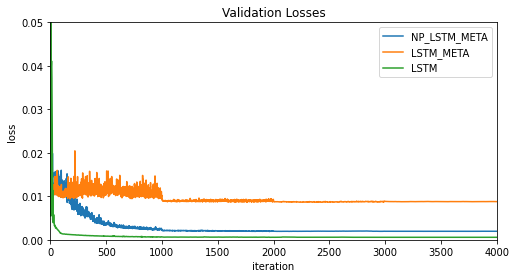

In [26]:
# Visualize losses
for model in ['NP_LSTM_META', 'LSTM_META', 'LSTM']:
    file = os.path.join(GOOGLE_DRIVE_PATH, model, 'loss_history.pickle')
    with open(file, 'rb') as f:
        val_losses = pickle.load(f)
    plt.plot(val_losses, label=model)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Validation Losses')
plt.xlim(0, 4000)
plt.ylim(0, 0.05)
plt.legend()
plt.gcf().set_size_inches(8, 4)
plt.show()

# Possible ML methods to visualize 

In [ ]:
from sklearn import mixture
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn import decomposition

# pca = decomposition.PCA(n_components=60)
# pca.fit(val)
# test_result0 = pca.transform(test_result)
# val0 = pca.transform(val)
# test_result_dtc0 = pca.transform(test_result_dtc)

g = EllipticEnvelope(contamination=0.01, random_state=0)
# g = OneClassSVM(gamma='auto', degree=5, kernel='rbf',nu=0.1)
# g = mixture.GaussianMixture(n_components=1, covariance_type='full', max_iter=100000)
# g = IsolationForest(contamination=0.015, n_estimators=5000, behaviour='new', max_samples=2000)
# g.fit(val0) 
# print(np.sum(np.sum((g.predict(val0)>0)*1)/val0.shape[0]))
# print(np.sum(np.sum((g.predict(test_result0)>0)*1)/test_result0.shape[0]))
# print(np.sum(np.sum((g.predict(test_result_dtc0)<0)*1)/test_result_dtc0.shape[0]))

# Testing

In [27]:
def getNum(val_diff, val_list):
    val_diff = np.std(val_diff, axis=1)
    each_case = np.sum(val_diff > val_list, axis=1)
    return np.sum(each_case > 1)

In [28]:
# record some data for visualization
sample_vehicle = 3 # only plot for one vehicle
record_val = [] # keeps track of thresholds in normal validation data (16, ) * 3
record_ab = [] # keeps track of sample stds in abnormal data (100, 16) * 3
record_test = [] # keeps track of sample stds in normal test data (100, 16) * 3

## Test NP_LSTM_META

In [ ]:
net = NP_LSTM().cuda()
net.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'NP_LSTM_META/model_3760_0.00195.ckpt'))) # model with meta learning

batch_size = 100

# test
val_list = []  
for vehicle in validation:
    x_batch = validation[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = validation[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)
    x_context = x_batch[:80, :, :]
    y_context = y_batch[:80, :, :]

    x_target = x_batch[80:, :, :]
    y_target = y_batch[80:, :, :]

    y_pred, _, _ = net(x_context, y_context, x_target)
    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_target.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    val_diff = val_diff.reshape([-1, 16])
#     val_diff = np.std(val_diff, axis=0)
    mean = np.mean(val_diff, axis=0)
    std = np.std(val_diff, axis=0)
#     thresh = np.mean(val_diff, axis=0)
    thresh = abs(mean) + 3 * std
    val_list.append(thresh)
val_np = np.array(val_list)

# record data for visualization
record_val.append(val_list[sample_vehicle])

ab_np_list = []
i = 0
for vehicle in ab:
    x_batch = ab[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = ab[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)
    x_context = x_batch[:80, :, :]
    y_context = y_batch[:80, :, :]

    x_target = x_batch[80:, :, :]
    y_target = y_batch[80:, :, :]

    y_pred, _, _ = net(x_context, y_context, x_target)
    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_target.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    
    ab_np_list.append(getNum(val_diff, val_list[i]))

    # record data for visualization
    if i == sample_vehicle:
        record_ab.append(val_diff)

    i += 1

test_np_list = []
i = 0
for vehicle in test:
    x_batch = test[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = test[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)
    x_context = x_batch[:80, :, :]
    y_context = y_batch[:80, :, :]

    x_target = x_batch[80:, :, :]
    y_target = y_batch[80:, :, :]

    y_pred, _, _ = net(x_context, y_context, x_target)
    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_target.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target

    test_np_list.append(getNum(val_diff, val_list[i]))

    # record data for visualization
    if i == sample_vehicle:
        record_test.append(val_diff)
  
    i += 1

In [ ]:
print(ab_np_list) # previously, [0, 31, 0, 14, 0, 7, 2, 0, 0]

In [ ]:
print(test_np_list) # previously, [0, 7, 0, 0, 1, 0, 0, 0, 0]

## Test LSTM_META

In [32]:
net = LSTM().cuda()
net.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'LSTM_META/model_3776_0.00876.ckpt'))) # model with meta learning

batch_size = 100

# test
val_list = []   
for vehicle in validation:
    x_batch = validation[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = validation[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    val_diff = val_diff.reshape([-1, 16])
#     val_diff = np.std(val_diff, axis=0)
    mean = np.mean(val_diff, axis=0)
    std = np.std(val_diff, axis=0)
#     thresh = np.mean(val_diff, axis=0)
    thresh = abs(mean) + 3 * std
    val_list.append(thresh)
val_np = np.array(val_list)

# record data for visualization
record_val.append(val_list[sample_vehicle])

i = 0
ab_meta_list = []
len_ab_meta_list = []
for vehicle in ab:
    x_batch = ab[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = ab[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    ab_meta_list.append(getNum(val_diff, val_list[i]))
    len_ab_meta_list.append(val_diff.shape[0])

    # record data for visualization
    if i == sample_vehicle:
        record_ab.append(val_diff)

    i += 1

i = 0
test_meta_list = []
len_test_meta_list = []
for vehicle in test:
    x_batch = test[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = test[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    test_meta_list.append(getNum(val_diff, val_list[i]))
    len_test_meta_list.append(val_diff.shape[0])

    # record data for visualization
    if i == sample_vehicle:
        record_test.append(val_diff)

    i += 1

In [33]:
print(ab_meta_list) # previously, [0, 4, 0, 6, 0, 15, 0, 0, 0]

[0, 14, 0, 2, 0, 14, 1, 0, 0]


In [34]:
print(test_meta_list) # previously, [0, 1, 1, 0, 0, 0, 0, 3, 0]

[0, 1, 0, 0, 0, 0, 0, 0, 0]


## Test LSTM

In [ ]:
net = LSTM().cuda()
net.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'LSTM/model_3793_0.00087.ckpt'))) # model without meta learning

batch_size = 100

# test
val_list = []   
for vehicle in validation:
    x_batch = validation[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = validation[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    val_diff = val_diff.reshape([-1, 16])
#     val_diff = np.std(val_diff, axis=0)
    mean = np.mean(val_diff, axis=0)
    std = np.std(val_diff, axis=0)
#     thresh = np.mean(val_diff, axis=0)
    thresh = abs(mean) + 3 * std
    val_list.append(thresh)
val_np = np.array(val_list)

# record data for visualization
record_val.append(val_list[sample_vehicle])

i = 0
ab_lstm_list = []
len_ab_lstm_list = []
for vehicle in ab:
    x_batch = ab[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = ab[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    ab_lstm_list.append(getNum(val_diff, val_list[i]))
    len_ab_lstm_list.append(val_diff.shape[0])

    # record data for visualization
    if i == sample_vehicle:
        record_ab.append(val_diff)

    i += 1

i = 0
test_lstm_list = []
len_test_lstm_list = []
for vehicle in test:
    x_batch = test[vehicle][:batch_size, :, :14].cuda().transpose(0, 1)
    y_batch = test[vehicle][:batch_size, :, 14:].cuda().transpose(0, 1)

    y_pred = net(x_batch)

    y_pred = y_pred.transpose(0, 1).cpu().detach().numpy()
    y_target = y_batch.transpose(0, 1).cpu().detach().numpy()
    
    val_diff = y_pred - y_target
    test_lstm_list.append(getNum(val_diff, val_list[i]))
    len_test_lstm_list.append(val_diff.shape[0])

    # record data for visualization
    if i == sample_vehicle:
        record_test.append(val_diff)

    i += 1

In [ ]:
print(ab_lstm_list)

In [ ]:
print(test_lstm_list)

# Visualization

In [ ]:
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(20, 10)
labels = ['abnormal w/ NP_LSTM and meta learning', 'abnormal w/ LSTM and meta learning', 'abnormal w/ LSTM']
for j in range(3): # 3 models
    stds_ab = np.std(record_ab[j], axis=1) # (N=100 instances, D=16 sensors)
    stds_test = np.std(record_test[j], axis=1) # (N=100 instances, D=16 sensors)
    stds_thresh = record_val[j] # (D=16 sensors, )
    for i in range(16):
        axs[i//4, i%4].scatter(range(j*100, (j+1)*100), stds_test[:,i], color='k', alpha=0.6, s=6)
        axs[i//4, i%4].scatter(range(j*100, (j+1)*100), stds_ab[:,i], alpha=1.0, s=6, label=labels[j])
        axs[i//4, i%4].plot([j*100+0, j*100+99], [stds_thresh[i]]*2)
        axs[i//4, i%4].set_xticks([])
        axs[i//4, i%4].set_ylabel('std')
        axs[i//4, i%4].set_title('Sensor ' + str(i+1))
axs[3, 3].legend(loc='upper right')
plt.show()

In [ ]:
labels = ['abnormal w/ NP_LSTM and meta learning', 'abnormal w/ LSTM and meta learning', 'abnormal w/ LSTM']
colors = ['r', 'g', 'b']
for i in [0, 3]:
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    for j in [2, 1, 0]: # 3 models
        stds_ab = np.std(record_ab[j], axis=1) # (N=100 instances, D=16 sensors)
        stds_test = np.std(record_test[j], axis=1) # (N=100 instances, D=16 sensors)
        stds_thresh = record_val[j] # (D=16 sensors, )

        axs[0].scatter(range(100), stds_test[:,i], alpha=0.8, s=20, label=labels[j], color=colors[j])
        axs[1].scatter(range(100), stds_ab[:,i], alpha=0.8, s=20, label=labels[j], color=colors[j])
        axs[1].plot([0, 99], [stds_thresh[i]]*2, color=colors[j])
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[0].set_ylabel('std')
    axs[1].set_ylabel('std')
    axs[0].set_ylim(0.00, 0.16)
    axs[1].set_ylim(0.00, 0.16)
    axs[0].set_title('Normal')
    axs[1].set_title('Abnormal')
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    fig.suptitle('Sensor ' + str(i+1))
    plt.show()